In [1]:
import xarray as xr
import pandas as pd
import altair as alt
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import altair as alt

import sys
sys.path.append('../../')
import sosutils
from gradients import LogLinear, CentralDifferencing, \
    LogPolynomial, LogPolynomialWithRoughness, Ri

# convenience function used for plotting legends properly
from collections.abc import Iterable
def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x

In [2]:
sos_ds = xr.open_dataset("example_dataset.nc")
sos_ds = sos_ds.drop_duplicates('time')

In [3]:
sos_ds = sos_ds.sel(time=slice("2023-01-05", "2023-01-05"))

# Calculate wind gradient, temp gradient, and Ri

In [4]:
sos_ds['wind_gradient_3m_c'] = (['time'], LogLinear.calculate_wind_gradient_for_height(sos_ds, 3, 'c').values)
sos_ds['wind_gradient_5m_c'] = (['time'], LogLinear.calculate_wind_gradient_for_height(sos_ds, 5, 'c').values)
sos_ds['wind_gradient_10m_c'] = (['time'], LogLinear.calculate_wind_gradient_for_height(sos_ds, 10, 'c').values)
sos_ds['wind_gradient_15m_c'] = (['time'], LogLinear.calculate_wind_gradient_for_height(sos_ds, 15, 'c').values)

sos_ds['wind_gradient_polynomial_2m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 2, 'c').values)
sos_ds['wind_gradient_polynomial_3m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 3, 'c').values)
sos_ds['wind_gradient_polynomial_5m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 5, 'c').values)
sos_ds['wind_gradient_polynomial_10m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 10, 'c').values)
sos_ds['wind_gradient_polynomial_15m_c'] = (['time'], LogPolynomial.calculate_wind_gradient_for_height(sos_ds, 15, 'c').values)

In [5]:
sos_ds['temp_gradient_3m_c'] = (['time'], CentralDifferencing.calculate_temperature_gradient_for_height(sos_ds, 3).values)
sos_ds['temp_gradient_5m_c'] = (['time'], CentralDifferencing.calculate_temperature_gradient_for_height(sos_ds, 5).values)
sos_ds['temp_gradient_10m_c'] = (['time'], CentralDifferencing.calculate_temperature_gradient_for_height(sos_ds, 10).values)
sos_ds['temp_gradient_15m_c'] = (['time'], CentralDifferencing.calculate_temperature_gradient_for_height(sos_ds, 15).values)

sos_ds['temp_gradient_polynomial_2m_c'] = (['time'], LogPolynomial.calculate_temperature_gradient_for_height(sos_ds, 2).values)
sos_ds['temp_gradient_polynomial_3m_c'] = (['time'], LogPolynomial.calculate_temperature_gradient_for_height(sos_ds, 3).values)
sos_ds['temp_gradient_polynomial_5m_c'] = (['time'], LogPolynomial.calculate_temperature_gradient_for_height(sos_ds, 5).values)
sos_ds['temp_gradient_polynomial_10m_c'] = (['time'], LogPolynomial.calculate_temperature_gradient_for_height(sos_ds, 10).values)
sos_ds['temp_gradient_polynomial_15m_c'] = (['time'], LogPolynomial.calculate_temperature_gradient_for_height(sos_ds, 15).values)

sos_ds['temp_gradient_wsurface_polynomial_2m_c'] = (['time'], LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(sos_ds, 2).values)
sos_ds['temp_gradient_wsurface_polynomial_3m_c'] = (['time'], LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(sos_ds, 3).values)
sos_ds['temp_gradient_wsurface_polynomial_5m_c'] = (['time'], LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(sos_ds, 5).values)
sos_ds['temp_gradient_wsurface_polynomial_10m_c'] = (['time'], LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(sos_ds, 10).values)
sos_ds['temp_gradient_wsurface_polynomial_15m_c'] = (['time'], LogPolynomialWithRoughness.calculate_temperature_gradient_for_height(sos_ds, 15).values)

In [6]:
sos_ds['Ri_3m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 3, 'c'))
sos_ds['Ri_5m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 5, 'c'))
sos_ds['Ri_10m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 10, 'c'))
sos_ds['Ri_15m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 15, 'c'))

sos_ds['Ri_polynomial_2m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 2, 'c', temp_gradient_prefix = 'temp_gradient_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_polynomial_3m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 3, 'c', temp_gradient_prefix = 'temp_gradient_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_polynomial_5m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 5, 'c', temp_gradient_prefix = 'temp_gradient_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_polynomial_10m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 10, 'c', temp_gradient_prefix = 'temp_gradient_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_polynomial_15m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 15, 'c', temp_gradient_prefix = 'temp_gradient_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))

sos_ds['Ri_wsurface_polynomial_2m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 2, 'c', temp_gradient_prefix = 'temp_gradient_wsurface_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_wsurface_polynomial_3m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 3, 'c', temp_gradient_prefix = 'temp_gradient_wsurface_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_wsurface_polynomial_5m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 5, 'c', temp_gradient_prefix = 'temp_gradient_wsurface_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_wsurface_polynomial_10m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 10, 'c', temp_gradient_prefix = 'temp_gradient_wsurface_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))
sos_ds['Ri_wsurface_polynomial_15m_c'] = (['time'], Ri.calculate_richardson_number(sos_ds, 15, 'c', temp_gradient_prefix = 'temp_gradient_wsurface_polynomial', wind_gradient_prefix='wind_gradient_polynomial'))

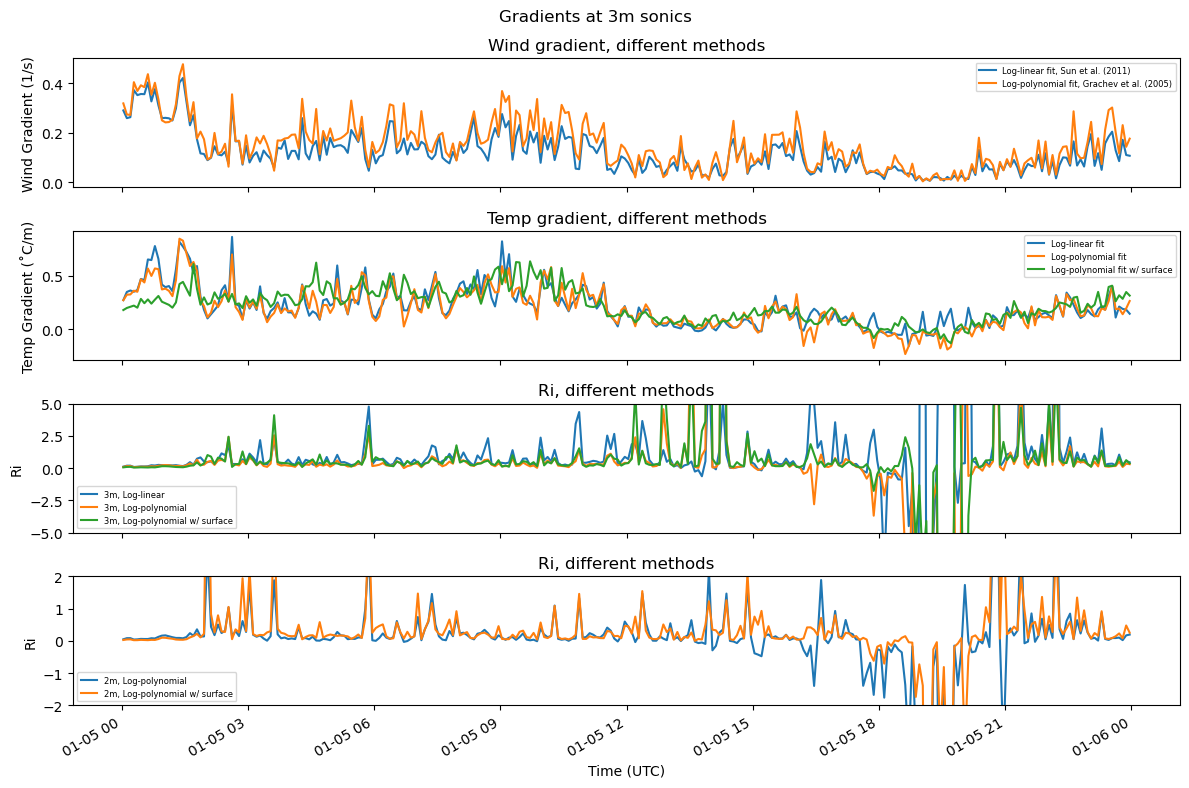

In [7]:

fig, axes = plt.subplots(4,1, figsize=(12,8), sharex=True)
sos_ds['wind_gradient_3m_c'].plot(label='Log-linear fit, Sun et al. (2011)', ax=axes[0])
sos_ds['wind_gradient_polynomial_3m_c'].plot(label='Log-polynomial fit, Grachev et al. (2005)', ax=axes[0])
axes[0].set_title("Wind gradient, different methods")
axes[0].set_ylabel("Wind Gradient (1/s)")

sos_ds['temp_gradient_3m_c'].plot(label='Log-linear fit', ax = axes[1])
sos_ds['temp_gradient_polynomial_3m_c'].plot(label='Log-polynomial fit', ax = axes[1])
sos_ds['temp_gradient_wsurface_polynomial_3m_c'].plot(label='Log-polynomial fit w/ surface', ax = axes[1])
axes[1].set_title("Temp gradient, different methods")
axes[1].set_ylabel("Temp Gradient (˚C/m)")

sos_ds['Ri_3m_c'].plot(label='3m, Log-linear', ax=axes[2])
sos_ds['Ri_polynomial_3m_c'].plot(label='3m, Log-polynomial', ax=axes[2])
sos_ds['Ri_wsurface_polynomial_3m_c'].plot(label='3m, Log-polynomial w/ surface', ax=axes[2])
axes[2].set_title("Ri, different methods")
axes[2].set_ylabel("Ri")
axes[2].set_ylim(-5,5)

# sos_ds['Ri_2m_c'].plot(label='2m, Log-linear', ax=axes[3])
sos_ds['Ri_polynomial_2m_c'].plot(label='2m, Log-polynomial', ax=axes[3])
sos_ds['Ri_wsurface_polynomial_2m_c'].plot(label='2m, Log-polynomial w/ surface', ax=axes[3])
axes[3].set_title("Ri, different methods")
axes[3].set_ylabel("Ri")
axes[3].set_ylim(-2,2)

axes[0].legend(prop={'size': 6})
axes[1].legend(prop={'size': 6})
axes[2].legend(prop={'size': 6})
axes[3].legend(prop={'size': 6})

axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")
axes[3].set_xlabel("Time (UTC)")
plt.suptitle("Gradients at 3m sonics")
plt.tight_layout()

plt.show()



In [8]:
src = sos_ds.to_dataframe().reset_index().melt(
    id_vars = ['time'],
    value_vars=['wind_gradient_3m_c', 'wind_gradient_5m_c', 'wind_gradient_10m_c', 'wind_gradient_15m_c',
    'wind_gradient_polynomial_3m_c', 'wind_gradient_polynomial_5m_c', 'wind_gradient_polynomial_10m_c', 'wind_gradient_polynomial_15m_c']
)
src['height'] = src['variable'].str.split('_').apply(lambda ls: int(ls[-2][:-1]))
src['method'] = src['variable'].str.split('_').apply(lambda ls: ' '.join(ls[:-2]))


alt.Chart(src).mark_bar(opacity=0.5).encode(
    alt.X("value:Q").bin(maxbins=50),
    alt.Y("count():Q").stack(None),
    alt.Color("method:N"),
    alt.Facet("height:O")    
).properties(height = 75, width=250)

alt.Chart(...)

In [9]:


src = sos_ds.to_dataframe().reset_index().melt(
    id_vars = ['time'],
    value_vars=['temp_gradient_3m_c', 'temp_gradient_5m_c', 'temp_gradient_10m_c', 'temp_gradient_15m_c', 'temp_gradient_polynomial_3m_c', 'temp_gradient_polynomial_5m_c', 'temp_gradient_polynomial_10m_c', 'temp_gradient_polynomial_15m_c', 'temp_gradient_wsurface_polynomial_3m_c', 'temp_gradient_wsurface_polynomial_5m_c', 'temp_gradient_wsurface_polynomial_10m_c', 'temp_gradient_wsurface_polynomial_15m_c']
)
src['height'] = src['variable'].str.split('_').apply(lambda ls: int(ls[-2][:-1]))
src['method'] = src['variable'].str.split('_').apply(lambda ls: ' '.join(ls[:-2]))

alt.Chart(src).mark_bar(opacity=0.5).encode(
    alt.X("value:Q").bin(maxbins=100),
    alt.Y("count():Q").stack(None),
    # alt.Color("method:N"),
    # alt.Facet(row="height:O")    
    alt.Column("height:O"),
    alt.Row("method:N")
).properties(height = 75, width=250)

alt.Chart(...)

In [10]:
src.method.unique()

array(['temp gradient', 'temp gradient polynomial',
       'temp gradient wsurface polynomial'], dtype=object)

In [11]:




src = sos_ds.to_dataframe().reset_index().melt(
    id_vars = ['time'],
    value_vars=['Ri_3m_c' ,'Ri_5m_c' ,'Ri_10m_c' ,'Ri_15m_c' ,'Ri_polynomial_3m_c' ,'Ri_polynomial_5m_c' ,'Ri_polynomial_10m_c' ,'Ri_polynomial_15m_c' ,'Ri_wsurface_polynomial_3m_c' ,'Ri_wsurface_polynomial_5m_c' ,'Ri_wsurface_polynomial_10m_c' ,'Ri_wsurface_polynomial_15m_c']
)
src['height'] = src['variable'].str.split('_').apply(lambda ls: int(ls[-2][:-1]))
src['method'] = src['variable'].str.split('_').apply(lambda ls: ' '.join(ls[:-2]))


alt.Chart(src[np.abs(src['value']) < 10]).mark_bar(opacity=0.5).encode(
    alt.X("value:Q").bin(maxbins=100).axis(values=[-10,-5,0,5,10]),
    alt.Y("count():Q").stack(None),
    # alt.Color("method:N"),
    # alt.Facet("height:O")    
    alt.Column("height:O"),
    alt.Row("method:N")
).properties(height = 75, width=250)

alt.Chart(...)

# Show example profiles

In [12]:
ex_ds = sos_ds.resample(time='30Min').mean()

## log-linear curves, e.g. Sun et al., 2011

In [ ]:
# set the heights we will use for:
#    - observed and fitted velocity profiles
#    - observed and fitted temperature profiles
Z0 = 0.005
velocity_heights = [2,3,5,10,15,20]

temp_heights = [2] + list(range(4,21))
temp_wsurface_heights = [Z0, 2] + list(range(4,21))


# Iterate over each timestamp, get measured data at each height for each timestamp, fit curves, 
# and then get data for predicted profiles (at high resolution, so fitted the curves look nice plotted)

# initialize lists for profiles of measured data
u_values_ls = []
v_values_ls = []
spd_values_ls = []
dir_values_ls = []
temp_values_ls = []

# initialize lists for profiles of predicted data
u_fitted_values_logpoly = []
v_fitted_values_logpoly = []
u_fitted_values_loglinear = []
v_fitted_values_loglinear = []
temp_fitted_values_loglinear = []
temp_fitted_values_logpoly = []
temp_fitted_values_logpoly_wsurface = []

temp_predicted_heights = np.linspace(Z0, 20, 100)

for t in ex_ds.time:
    # collect observed data
    u_values = [ex_ds.sel(time = t)[f'u_{h}m_c'].values.item() for h in velocity_heights]
    v_values = [ex_ds.sel(time = t)[f'v_{h}m_c'].values.item() for h in velocity_heights]
    spd_values = [ex_ds.sel(time = t)[f'spd_{h}m_c'].values.item() for h in velocity_heights]
    dir_values = [ex_ds.sel(time = t)[f'dir_{h}m_c'].values.item() for h in velocity_heights]

    temp_values = [
        ex_ds.sel(time = t)[f'Tpotvirtual_{h}m_c'].values.item() for h in temp_heights
    ]
    temp_wsurface_values = [
        ex_ds.sel(time = t)['Tsurfpotvirtual_rad_c'].values.item() if h == Z0 else
        ex_ds.sel(time = t)[f'Tpotvirtual_{h}m_c'].values.item() for h in temp_wsurface_heights
    ]

    # collected observed profile data
    u_values_ls.append(u_values)
    v_values_ls.append(v_values)
    spd_values_ls.append(spd_values)
    dir_values_ls.append(dir_values)
    temp_values_ls.append(temp_wsurface_values)
    

    # FIT u AND v
    #    get params
    u_params_loglinear = LogLinear.fit_function(u_values, velocity_heights)
    v_params_loglinear = LogLinear.fit_function(v_values, velocity_heights)
    u_params_logpoly = LogPolynomial.fit_function(u_values, velocity_heights)
    v_params_logpoly = LogPolynomial.fit_function(v_values, velocity_heights)
    #    collect predicted profile data
    u_fitted_values_loglinear.append([LogLinear.function(h, *u_params_loglinear) for h in velocity_heights])
    v_fitted_values_loglinear.append([LogLinear.function(h, *v_params_loglinear) for h in velocity_heights])
    u_fitted_values_logpoly.append([LogPolynomial.function(h, *u_params_logpoly) for h in velocity_heights])
    v_fitted_values_logpoly.append([LogPolynomial.function(h, *v_params_logpoly) for h in velocity_heights])

    # FIT temps
    #    get params
    temp_params_loglinear = LogLinear.fit_function(temp_values, temp_heights)
    temp_params_logpoly = LogPolynomial.fit_function(temp_values, temp_heights)
    temp_wsurface_params_logpoly = LogPolynomialWithRoughness.fit_function(temp_wsurface_values, temp_wsurface_heights)
    #    collect predicted profile data
    temp_fitted_values_loglinear.append([LogLinear.function(h, *temp_params_loglinear) for h in temp_predicted_heights])
    temp_fitted_values_logpoly.append([LogPolynomial.function(h, *temp_params_logpoly) for h in temp_predicted_heights])
    temp_fitted_values_logpoly_wsurface.append([LogPolynomialWithRoughness.function(h, *temp_wsurface_params_logpoly) for h in temp_predicted_heights])

## linear polynomial curve, e.g., Grachev et al., 2005

## log-linear curves, e.g. Sun et al., 2011

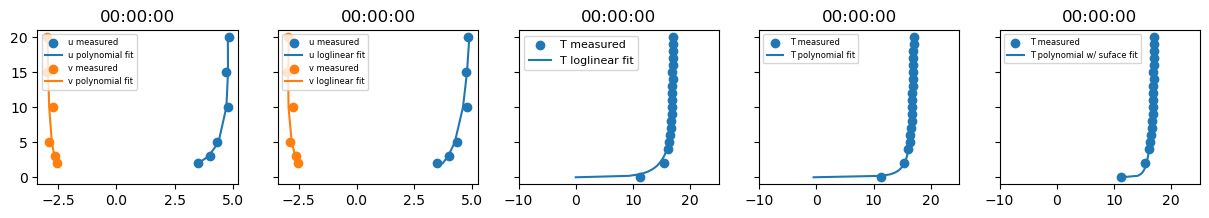

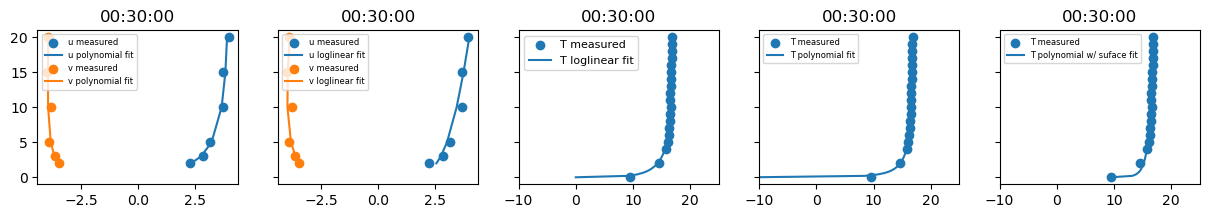

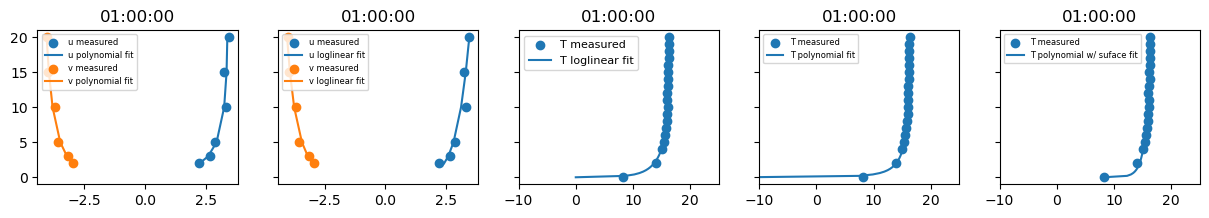

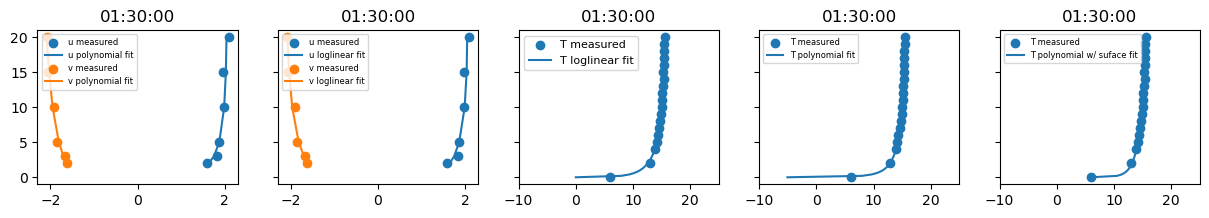

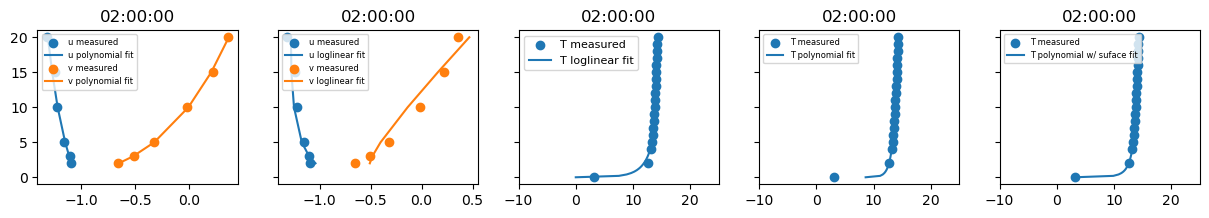

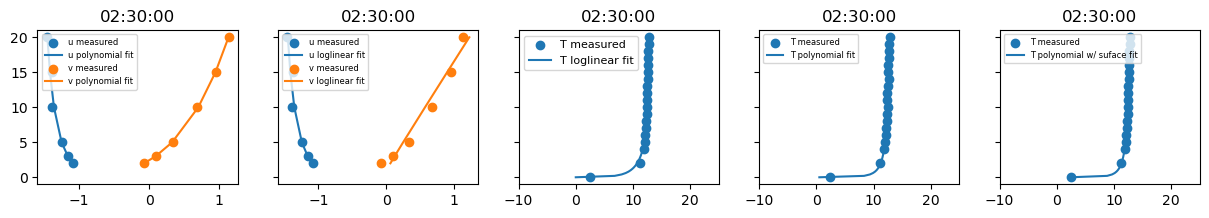

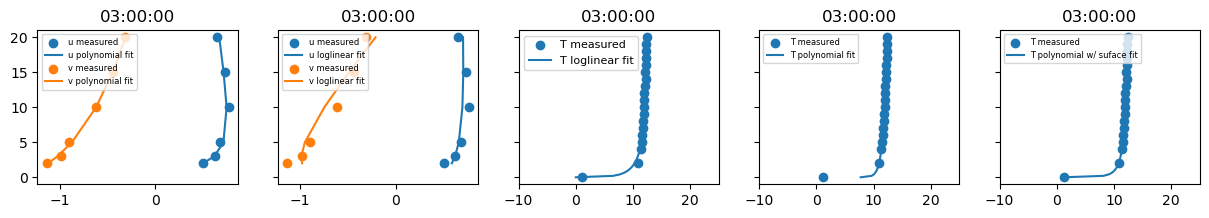

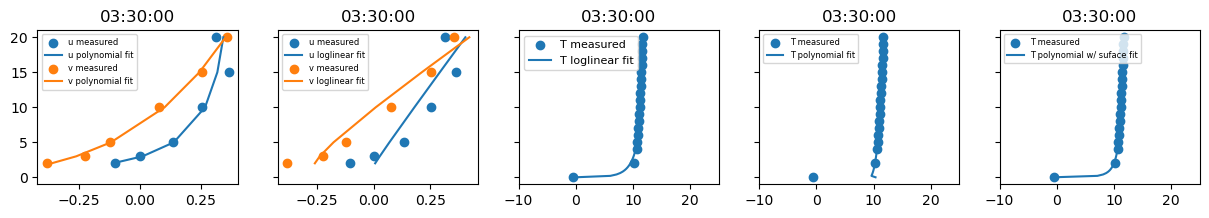

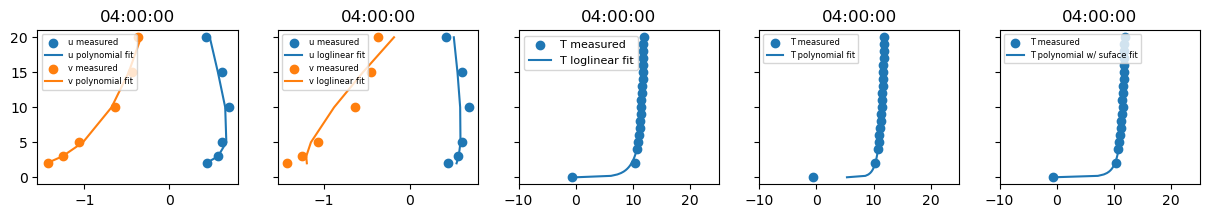

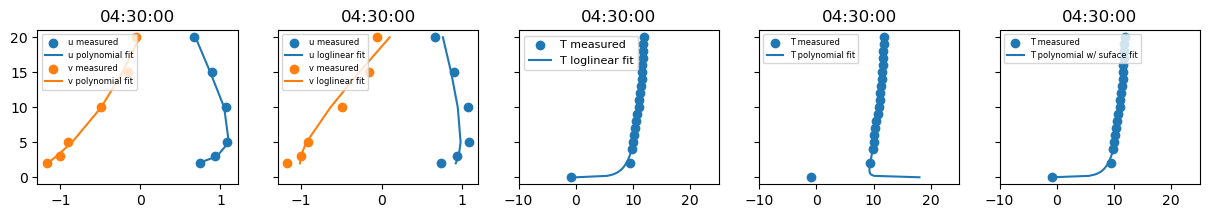

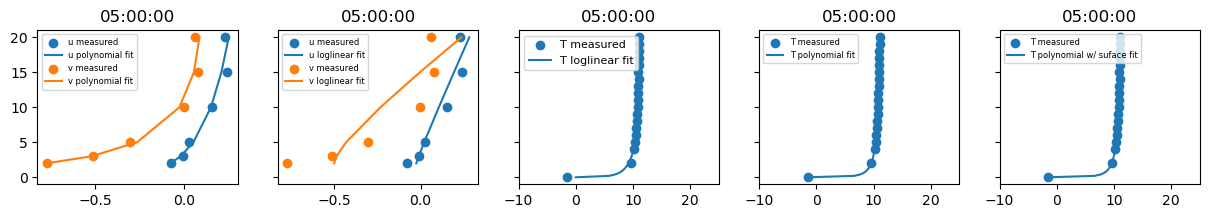

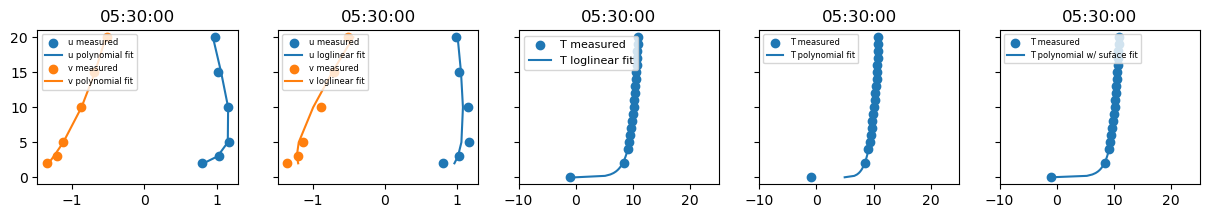

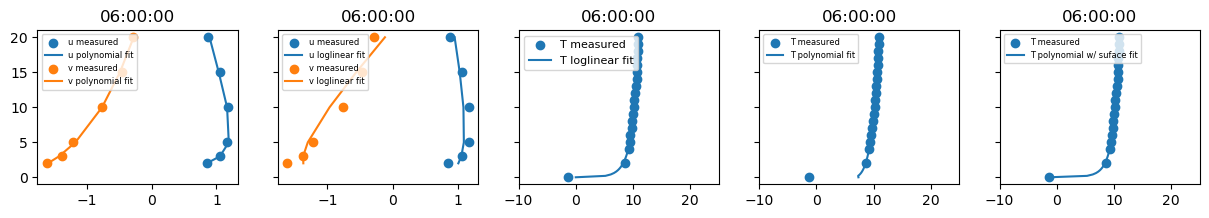

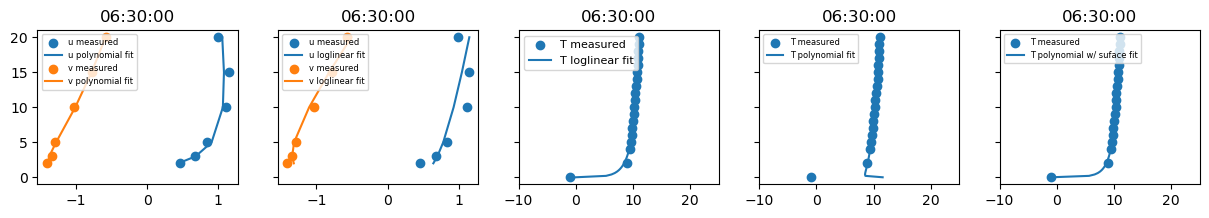

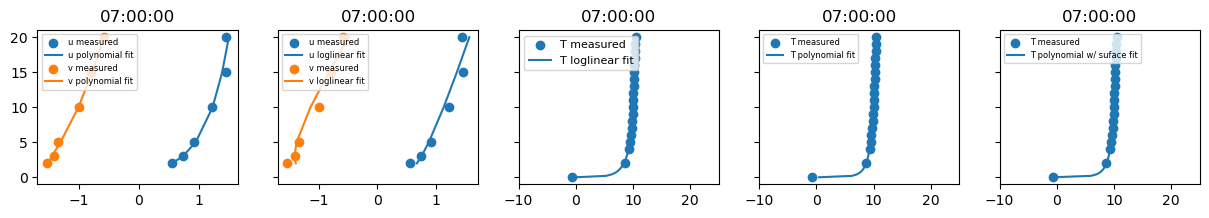

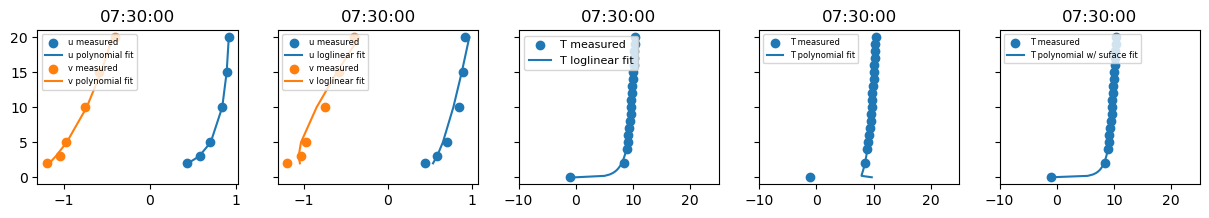

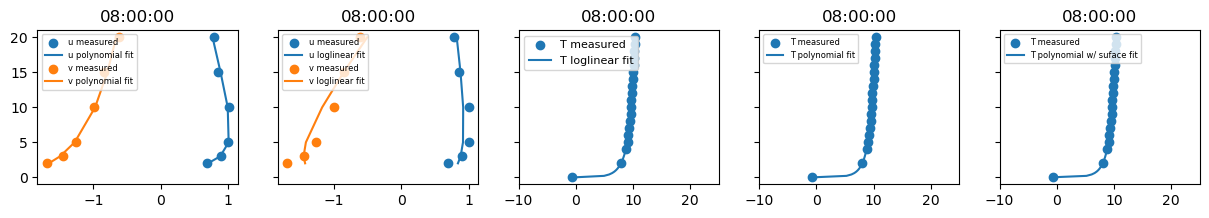

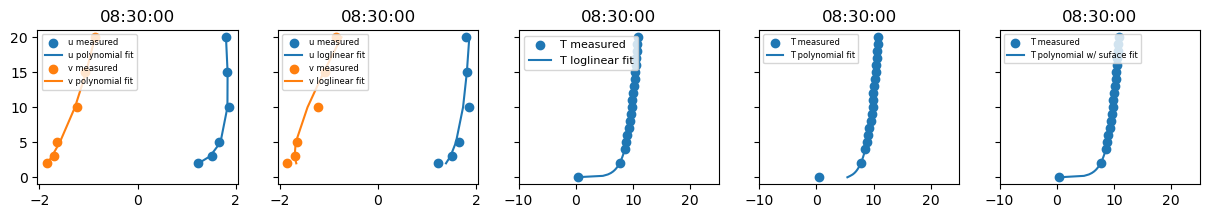

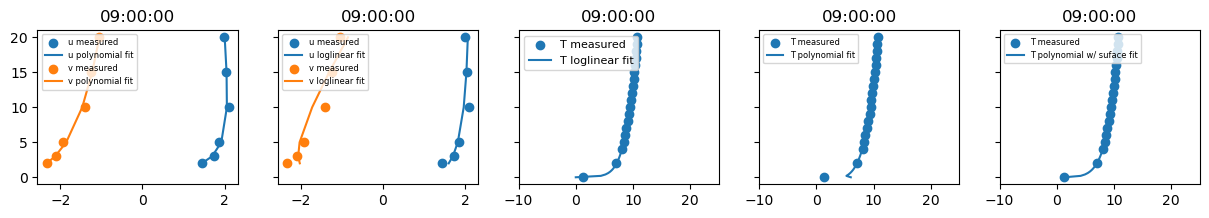

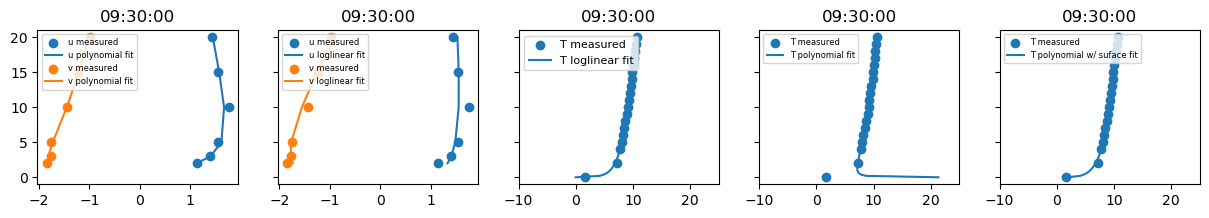

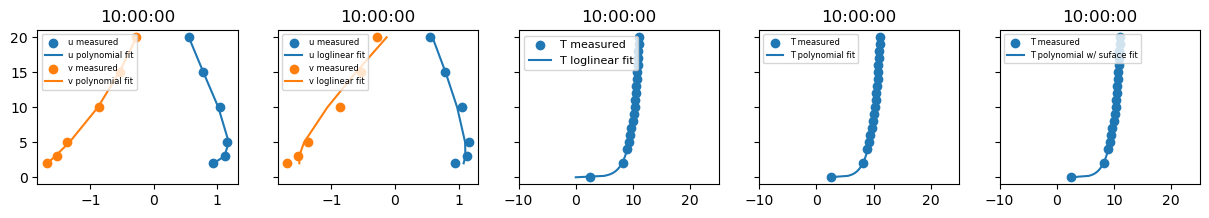

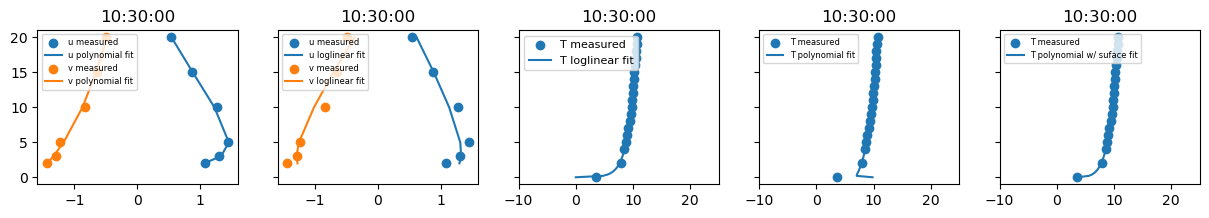

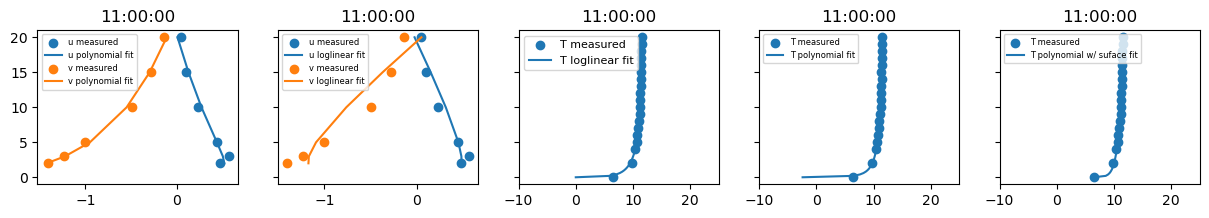

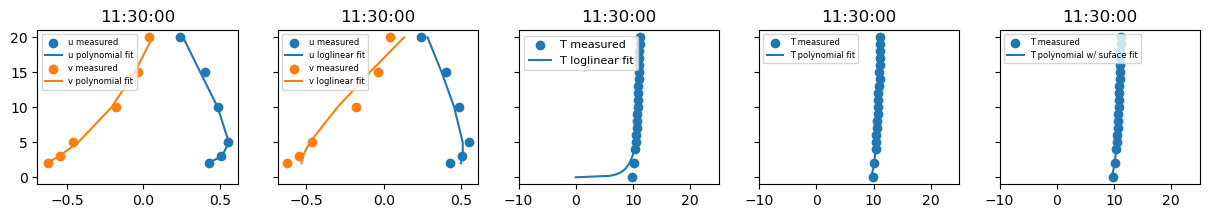

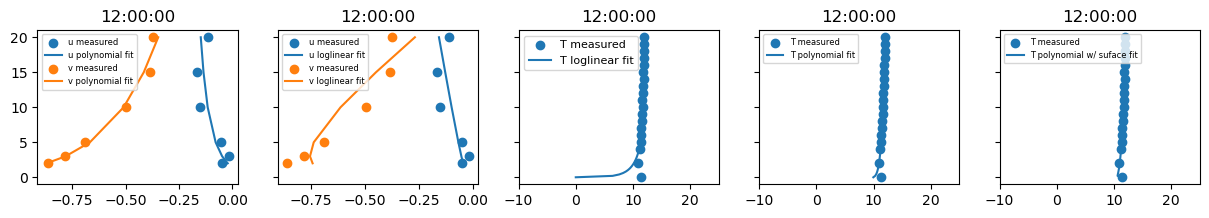

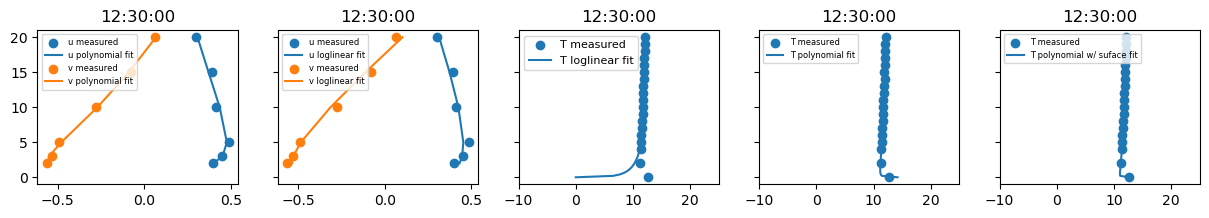

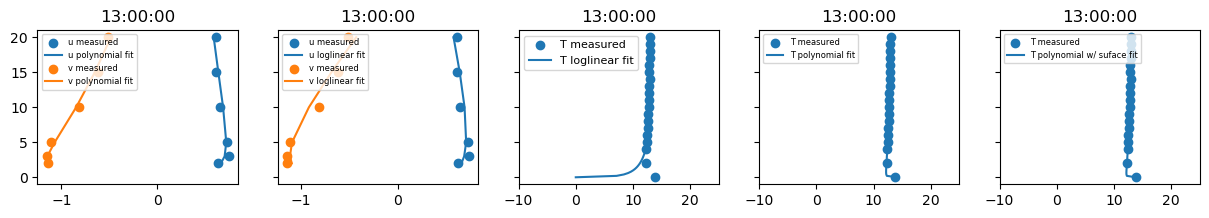

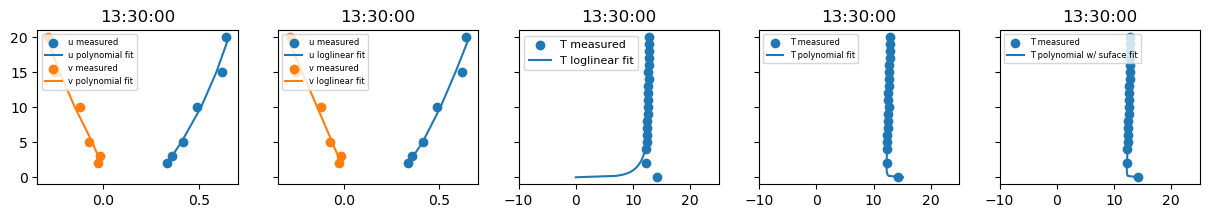

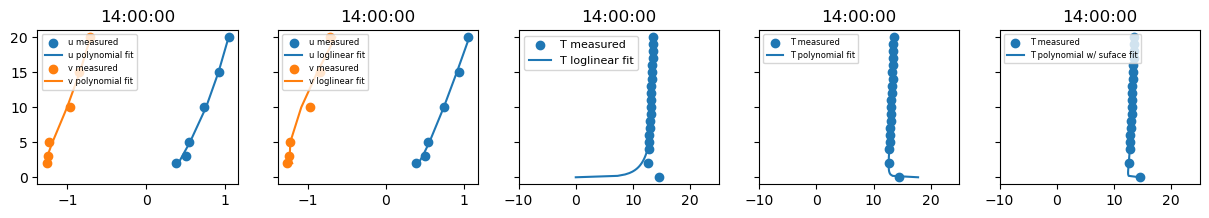

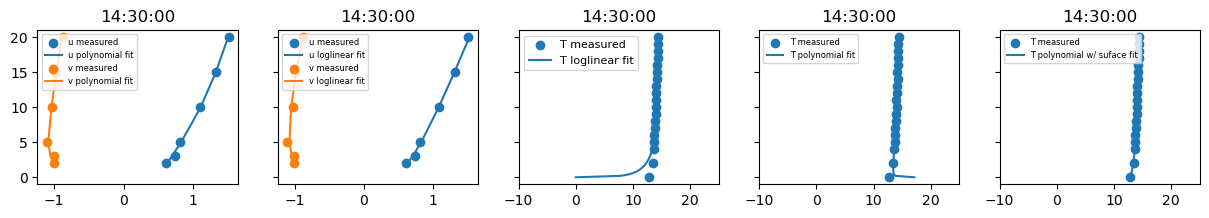

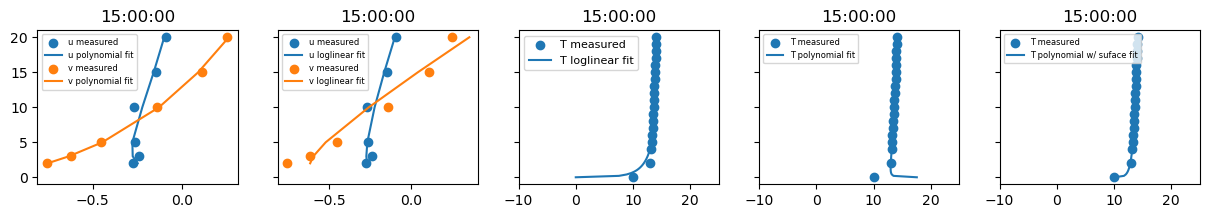

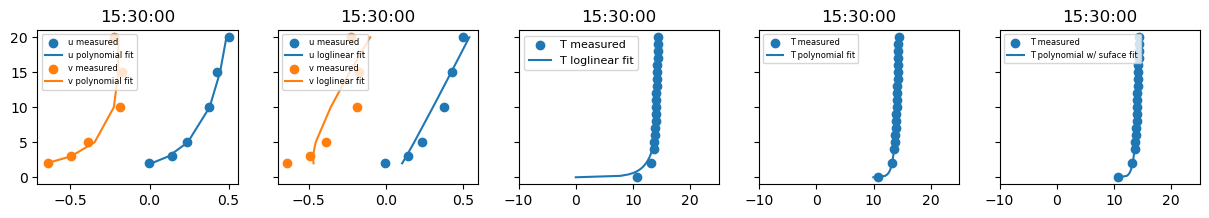

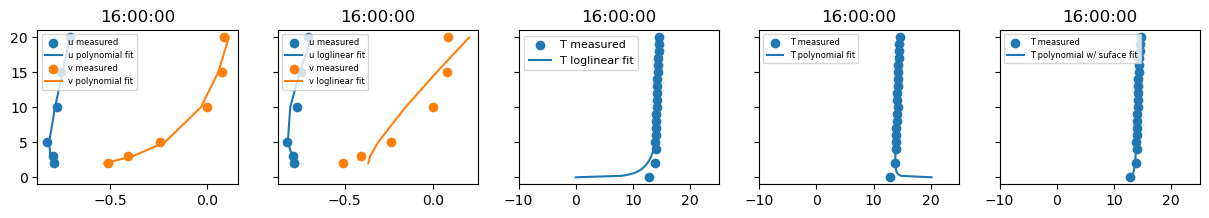

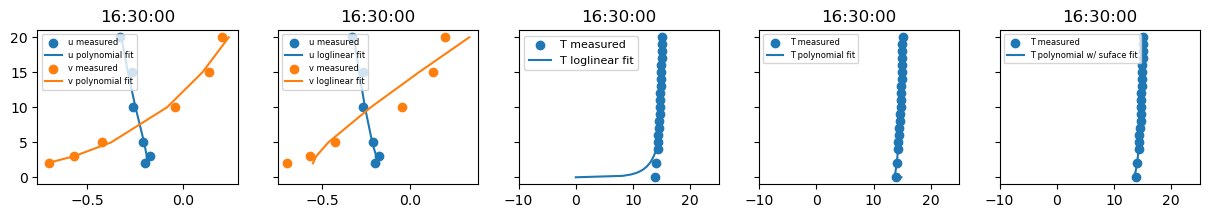

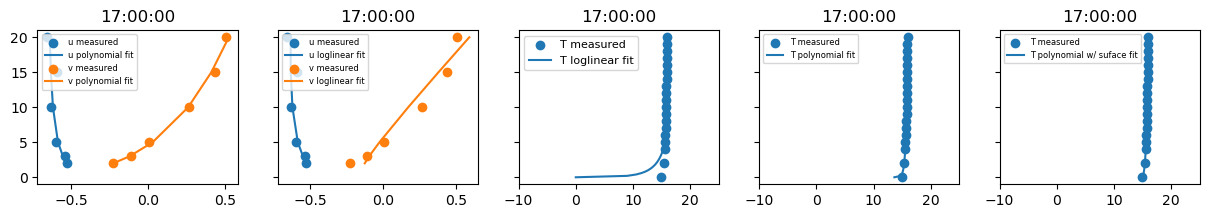

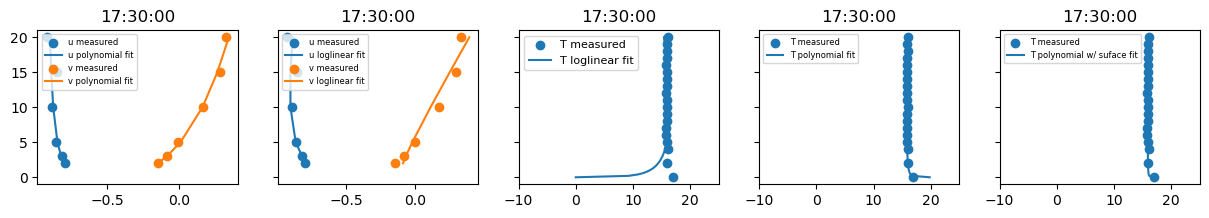

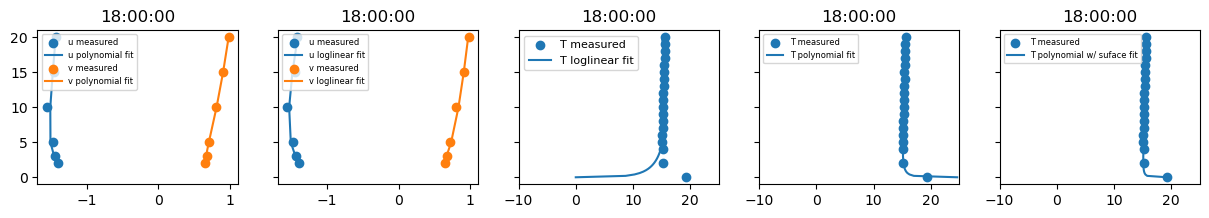

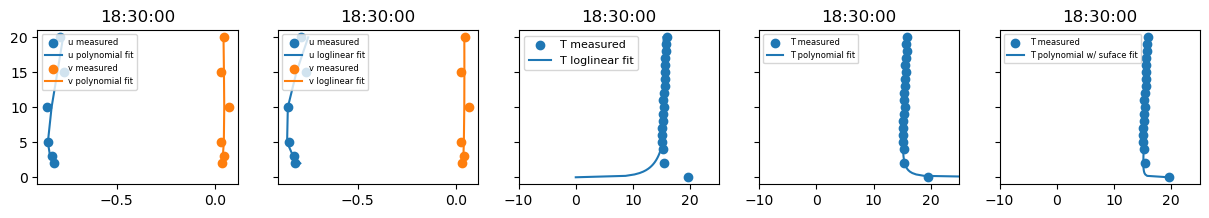

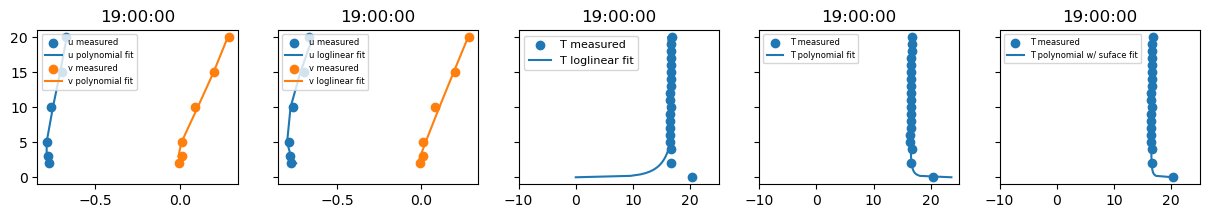

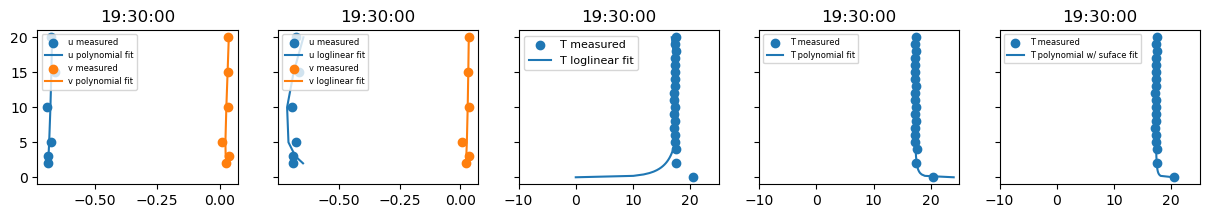

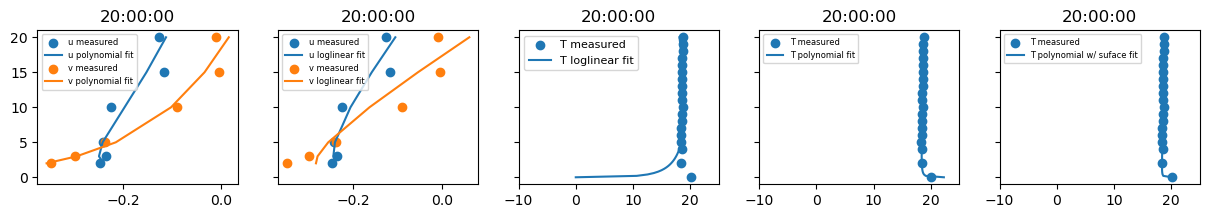

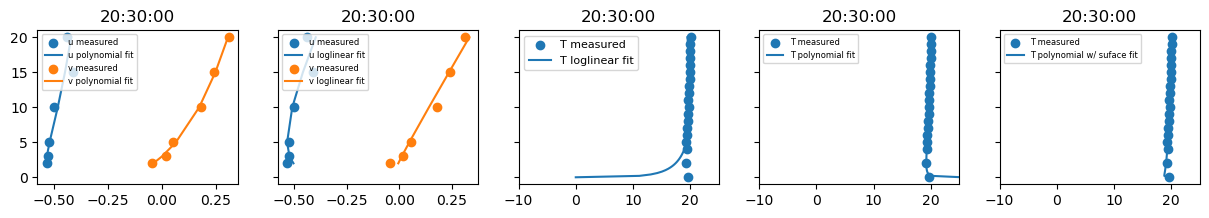

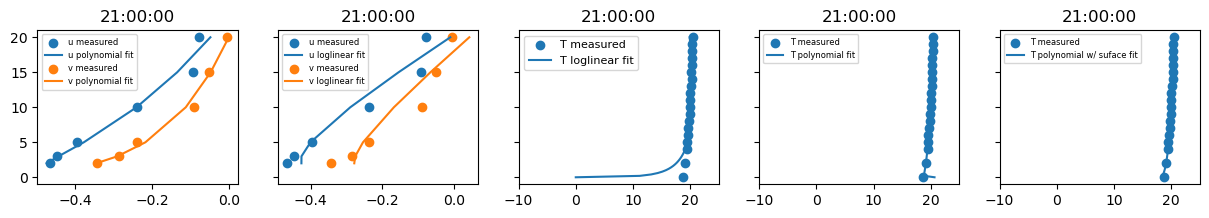

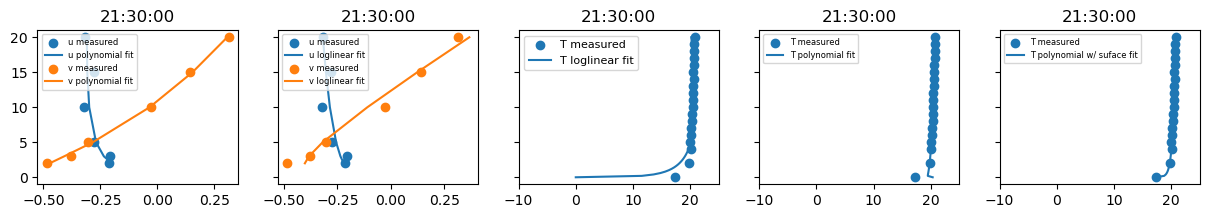

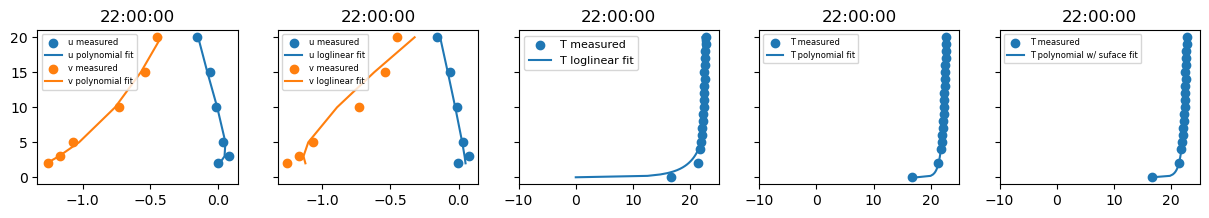

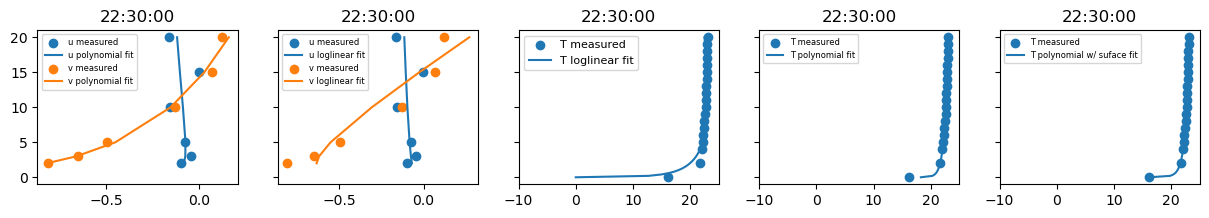

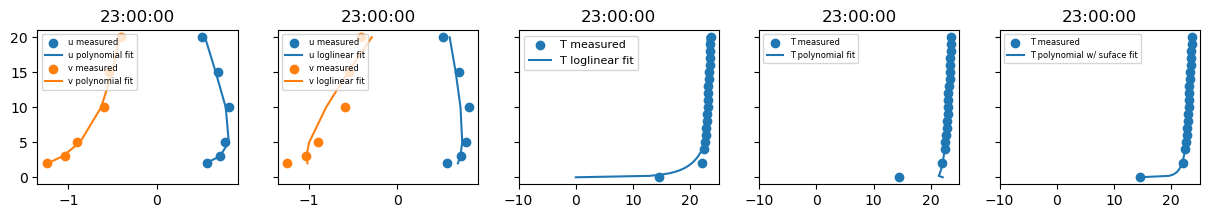

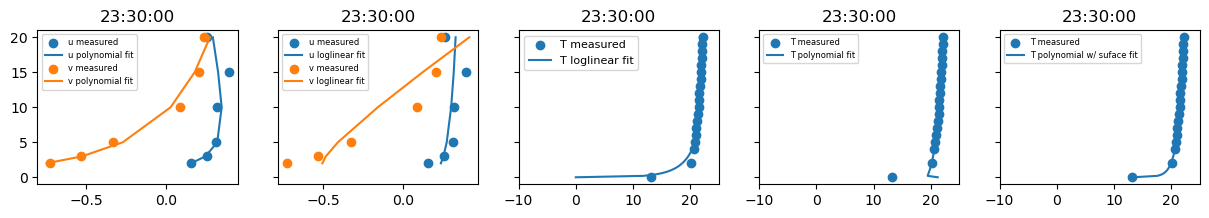

In [ ]:
for i,t in enumerate(ex_ds.time):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(15,2), sharey=True)
    ax1.scatter(u_values_ls[i], velocity_heights, label='u measured')
    ax1.plot(u_fitted_values_logpoly[i], velocity_heights, label='u polynomial fit')
    ax1.scatter(v_values_ls[i], velocity_heights, label='v measured')
    ax1.plot(v_fitted_values_logpoly[i], velocity_heights, label='v polynomial fit')

    ax2.scatter(u_values_ls[i], velocity_heights, label='u measured')
    ax2.plot(u_fitted_values_loglinear[i], velocity_heights, label='u loglinear fit')
    ax2.scatter(v_values_ls[i], velocity_heights, label='v measured')
    ax2.plot(v_fitted_values_loglinear[i], velocity_heights, label='v loglinear fit')

    ax3.scatter(temp_values_ls[i], temp_wsurface_heights, label='T measured')
    ax3.plot(temp_fitted_values_loglinear[i], temp_predicted_heights, label='T loglinear fit')

    ax4.scatter(temp_values_ls[i], temp_wsurface_heights, label='T measured')
    ax4.plot(temp_fitted_values_logpoly[i], temp_predicted_heights, label='T polynomial fit')

    ax5.scatter(temp_values_ls[i], temp_wsurface_heights, label='T measured')
    ax5.plot(temp_fitted_values_logpoly_wsurface[i], temp_predicted_heights, label='T polynomial w/ suface fit')
    
    ax3.set_xlim(-10,25);    ax4.set_xlim(-10,25);    ax5.set_xlim(-10,25)
    
    ax1.set_title(pd.to_datetime(t.item()).time())
    ax2.set_title(pd.to_datetime(t.item()).time())
    ax3.set_title(pd.to_datetime(t.item()).time())
    ax4.set_title(pd.to_datetime(t.item()).time())
    ax5.set_title(pd.to_datetime(t.item()).time())

    ax1.legend(loc='upper left', prop={'size': 6}); ax2.legend(loc='upper left', prop={'size': 6}); ax3.legend(loc='upper left', prop={'size': 8})
    ax4.legend(loc='upper left', prop={'size': 6}); ax5.legend(loc='upper left', prop={'size': 6})
    plt.show()